# Programming Assignment 1: MNIST Classification using MLP
## EE5179:Deep Learning for Imaging
## Classification using MLP


**Name:** Saranath P \
**Roll No:** ns24z458

# All imports

In [1]:
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from datetime import datetime
import torch
from torchvision import datasets
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.transforms import ToTensor

# Helper classes and functions.

We will first get some helper classes and functions which will be used for implementing the backpropogation algorithm from scratch

## Loss functions

We define a class on various loss functions

In [ ]:
class LossFunctions:

    class SquaredErrorLoss:
        def __init__(self, alpha=0.01, regularization='l2'):
            """
            Initializes the SquaredErrorLoss with optional L1 or L2 regularization.

            Parameters:
            alpha (float): Regularization constant.
            regularization (str): Type of regularization ('l1' for L1, 'l2' for L2, or None).
            """
            self.alpha = alpha
            self.regularization = regularization

        def __call__(self, y_pred, y_true, model_weights=None):
            """
            Computes the Mean Squared Error (MSE) with optional L1 or L2 regularization.

            Parameters:
            y_pred (ndarray): The predicted values.
            y_true (ndarray): The true values.
            model_weights (list): A list of model weights (e.g., numpy arrays).

            Returns:
            float: The regularized mean squared error.
            """
            mse_loss = 0.5 * np.mean((y_pred - y_true) ** 2)

            # Regularization term
            if self.regularization == 'l2':
                reg_term = self.alpha * sum(np.sum(w ** 2) for w in model_weights)
            elif self.regularization == 'l1':
                reg_term = self.alpha * sum(np.sum(np.abs(w)) for w in model_weights)
            else:
                reg_term = 0  # No regularization

            return mse_loss + reg_term

        def gradient(self, y_pred, y_true, model_weights=None):
            """
            Computes the gradient of the Mean Squared Error (MSE) Loss with respect to y_pred,
            including the gradient of the regularization term.

            Parameters:
            y_pred (ndarray): The predicted values.
            y_true (ndarray): The true values.
            model_weights (list): A list of model weights (e.g., numpy arrays).

            Returns:
            tuple: The gradient with respect to y_pred and the gradients with respect to the model weights.
            """
            gradient_y_pred = 2 * (y_pred - y_true)


            gradients_weights = []
            if model_weights is not None:
                for w in model_weights:
                    if self.regularization == 'l2':
                        grad_w = self.alpha * w
                    elif self.regularization == 'l1':
                        grad_w = self.alpha * np.sign(w)
                    else:
                        grad_w = np.zeros_like(w)
                    gradients_weights.append(grad_w)

            return gradient_y_pred, gradients_weights

        def __repr__(self):
            return f"SquaredErrorLoss(alpha={self.alpha}, regularization={self.regularization})"



    class CrossEntropyLoss:
        def __init__(self, alpha=0.01, regularization=None):
            self.alpha = alpha
            self.regularization = regularization

        def __call__(self, y_pred, y_true, model_weights):

            y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
            ce_loss = -np.sum(y_true * np.log(y_pred))


            if self.regularization == 'l2':
                reg_term = self.alpha * sum(np.sum(w ** 2) for w in model_weights)
            elif self.regularization == 'l1':
                reg_term = self.alpha * sum(np.sum(np.abs(w)) for w in model_weights)
            else:
                reg_term = 0

            return ce_loss + reg_term

        def gradient(self, y_pred, y_true, model_weights):
            """
            Compute the gradient of the Cross-Entropy Loss with respect to y_pred,
            including the gradient of the regularization term.

            Parameters:
            y_pred (ndarray): The predicted probabilities (output of softmax) of shape (num_classes,).
            y_true (ndarray): The one-hot encoded true labels of shape (num_classes,).
            model_weights (list): A list of model weights (e.g., numpy arrays).

            Returns:
            list: A list containing the gradient with respect to y_pred and the gradients
                  with respect to the model weights.
            """

            y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
            gradient_y_pred = -(y_true / y_pred)


            gradients_weights = []
            for w in model_weights:
                if self.regularization == 'l2':
                    grad_w = self.alpha * w
                elif self.regularization == 'l1':
                    grad_w = self.alpha * np.sign(w)
                else:
                    grad_w = np.zeros_like(w)
                gradients_weights.append(grad_w)


            return gradient_y_pred, gradients_weights


        def __repr__(self):
            return f"CrossEntropyLoss(alpha={self.alpha}, regularization={self.regularization})"


## Activation functions

We define the activation functions and its gradients.

In [ ]:
class Activations:

    class ReLU:
        def __call__(self, x):
            """
            Applies the ReLU activation function element-wise to the given input x.

            Args:
                x (numpy array): The input array.

            Returns:
                numpy array: The output of the ReLU activation function, which is element-wise max(0, x).
            """
            return np.maximum(0, x)

        def gradient(self, x):
            """
            Computes the gradient (derivative) of the ReLU function for backpropagation.

            Args:
                x (numpy array): The input array.

            Returns:
                numpy array: The gradient of ReLU, which is 1 for x > 0 and 0 otherwise.
            """
            return np.where(x > 0, 1, 0)



    class Sigmoid:

        def __call__(self, x):
            """
            Applies the Sigmoid activation function to the given input x.

            Args:
                x (float): The input value.

            Returns:
                float: The output of the Sigmoid activation function.
            """
            return expit(x)

        def gradient(self, x):
            """
            Computes the gradient of the Sigmoid activation function.

            Args:
                x (float): The input value.

            Returns:
                float: The gradient of the Sigmoid activation function.
            """
            return self.__call__(x) * (1 - self.__call__(x))




    class Softmax:

        def __call__(self, x):
            """
            Applies the Softmax activation function to the given input x.

            Args:
                x (numpy.ndarray): The input array.

            Returns:
                numpy.ndarray: The output of the Softmax activation function.
            """
            exp_x = np.exp(x - np.max(x))  # Subtracting max(x) for numerical stability
            return exp_x / np.sum(exp_x, axis=0)

        def gradient(self, x):
            """
            Computes the gradient of the Softmax activation function.

            Args:
                x (numpy.ndarray): The input array.

            Returns:
                numpy.ndarray: The Jacobian matrix of the Softmax activation function.
            """
            s = self.__call__(x)
            jacobian_matrix = np.diagflat(s) - np.outer(s, s)
            return jacobian_matrix

        def __repr__(self):
            return "Softmax"


    class Tanh:

        def __call__(self, x):
            """
            Applies the Tanh activation function to the given input x.

            Args:
                x (numpy.ndarray): The input array.

            Returns:
                numpy.ndarray: The output of the Tanh activation function.
            """
            return np.tanh(x)

        def gradient(self, x):
            """
            Computes the gradient of the Tanh activation function.

            Args:
                x (numpy.ndarray): The input array.

            Returns:
                numpy.ndarray: The derivative of the Tanh activation function.
            """
            return 1 - np.power(self.__call__(x), 2)

    class Linear:

        def __call__(self, x):
            """
            Returns the input value.

            Parameters:
                x (Any): The input value.

            Returns:
                Any: The input value.
            """
            return x

        def gradient(self, x):
            """
            Computes the gradient of the Linear activation function.

            Args:
                x (Any): The input value.

            Returns:
                int: The derivative of the Linear activation function, which is always 1.
            """
            return 1

## Initialization

We define various initialization methods here

In [ ]:
import numpy as np

class ParameterInitializer:
    def __init__(self, initialization='random'):
        """
        Parameters:
        initialization (str): 'random' for uniform random initialization,
                              'gaussian' for Gaussian distribution,
                              'glorot' for Glorot initialization.
        """
        self.initialization = initialization

    def initialize_parameters(self, inputs, hidden_layers, outputs):
        """
        Initializes the parameters for a neural network.

        Args:
            inputs (int): The number of input nodes.
            hidden_layers (list): A list of integers representing the number of nodes in each hidden layer.
            outputs (int): The number of output nodes.

        Returns:
            dict: A dictionary containing the initialized parameters, with keys "W1" and "b1" for the first layer, and "W{i+1}" and "b{i+1}" for each hidden layer, where i is the index of the layer. The last two keys are "W{len(hidden_layers) + 1}" and "b{len(hidden_layers) + 1}" for the output layer.

        Raises:
            None.
        """
        parameters = {}

        if self.initialization == 'random':
            parameters["W1"] = np.random.rand(hidden_layers[0], inputs)
            parameters["b1"] = np.random.rand(hidden_layers[0])

        elif self.initialization == 'gaussian':
            parameters["W1"] = np.random.randn(hidden_layers[0], inputs)
            parameters["b1"] = np.random.randn(hidden_layers[0])

        elif self.initialization == 'glorot':
            parameters["W1"] = np.random.uniform(-np.sqrt(6 / (inputs + hidden_layers[0])),
                                                 np.sqrt(6 / (inputs + hidden_layers[0])),
                                                 (hidden_layers[0], inputs))
            parameters["b1"] = np.zeros(hidden_layers[0])

        for i in range(1, len(hidden_layers)):
            if self.initialization == 'random':
                parameters[f"W{i+1}"] = np.random.rand(hidden_layers[i], hidden_layers[i - 1])
                parameters[f"b{i+1}"] = np.random.rand(hidden_layers[i])
            elif self.initialization == 'gaussian':
                parameters[f"W{i+1}"] = np.random.randn(hidden_layers[i], hidden_layers[i - 1])
                parameters[f"b{i+1}"] = np.random.randn(hidden_layers[i])
            elif self.initialization == 'glorot':
                parameters[f"W{i+1}"] = np.random.uniform(-np.sqrt(6 / (hidden_layers[i - 1] + hidden_layers[i])),
                                                          np.sqrt(6 / (hidden_layers[i - 1] + hidden_layers[i])),
                                                          (hidden_layers[i], hidden_layers[i - 1]))
                parameters[f"b{i+1}"] = np.zeros(hidden_layers[i])

        if self.initialization == 'random':
            parameters[f"W{len(hidden_layers) + 1}"] = np.random.rand(outputs, hidden_layers[-1])
            parameters[f"b{len(hidden_layers) + 1}"] = np.random.rand(outputs)
        elif self.initialization == 'gaussian':
            parameters[f"W{len(hidden_layers) + 1}"] = np.random.randn(outputs, hidden_layers[-1])
            parameters[f"b{len(hidden_layers) + 1}"] = np.random.randn(outputs)
        elif self.initialization == 'glorot':
            parameters[f"W{len(hidden_layers) + 1}"] = np.random.uniform(-np.sqrt(6 / (hidden_layers[-1] + outputs)),
                                                                         np.sqrt(6 / (hidden_layers[-1] + outputs)),
                                                                         (outputs, hidden_layers[-1]))
            parameters[f"b{len(hidden_layers) + 1}"] = np.zeros(outputs)

        return parameters


# Feed Forward Neural Netowrk Implementation

In [ ]:
softmax = Activations.Softmax()
sigmoid = Activations.Sigmoid()
crossentropy = LossFunctions.CrossEntropyLoss()

class FeedForwardNeuralNets:
    def __init__(self, inputs, hidden_layers, outputs, g=sigmoid, L=crossentropy, O=softmax, eta=0.01,
                 optimizer="gd", initialization_method="glorot", batch_size=32,
                 beta1=0.9, beta2=0.999, epsilon=1e-8, t=0):
        self.inputs = inputs
        self.outputs = outputs
        self.batch_size = min(batch_size, inputs.shape[0])
        if len(self.outputs.shape) < 2:
            self.parameters = ParameterInitializer(initialization_method).initialize_parameters(
            inputs[0].shape[0], hidden_layers, 1)
        else:
            self.parameters = ParameterInitializer(initialization_method).initialize_parameters(
                inputs[0].shape[0], hidden_layers, outputs[0].shape[0])
        self.g = g
        self.O = O
        self.L = L
        self.eta = eta
        self.losses = {}
        self.activations = {}
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = t
        self.v = {key: np.zeros_like(value) for key, value in self.parameters.items()}
        self.s = {key: np.zeros_like(value) for key, value in self.parameters.items()}
        self.training_loss = []
        self.validation_loss = []


        if optimizer == "gd":
            self.optimizer = self.gradient_descent
        elif optimizer == "adam":
            self.optimizer = self.adam

    def forward_propogation(self, x):
        """
        Performs forward propagation through the neural network.

        Parameters:
            x (numpy array): The input to the neural network.

        Returns:
            y_pred (numpy array): The predicted output of the neural network.
        """

        self.activations["a1"] = self.parameters["W1"] @ x + self.parameters["b1"]
        self.activations["h1"] = self.g(self.activations["a1"])
        for i in range(2, len(self.parameters) // 2):
            self.activations[f"a{i}"] = self.parameters[f"W{i}"] @ self.activations[f"h{i - 1}"] + self.parameters[f"b{i}"]
            self.activations[f"h{i}"] = self.g(self.activations[f"a{i}"])

        self.activations[f"a{len(self.parameters) // 2}"] = self.parameters[f"W{len(self.parameters) // 2}"] @ self.activations[f"h{len(self.parameters) // 2 - 1}"] + self.parameters[f"b{len(self.parameters) // 2}"]
        y_pred = self.O(self.activations[f"a{len(self.parameters) // 2}"])
        return y_pred

    def backPropogation(self, y_pred, y, x):
        """
        Performs backpropagation through the neural network.

        Parameters:
            y_pred (numpy array): The predicted output of the neural network.
            y (numpy array): The actual output of the neural network.
            x (numpy array): The input to the neural network.

        Returns:
            None
        """
        n = len(self.parameters) // 2
        m = len(self.activations) // 2

        La = y_pred - y

        Lh = La @ self.parameters[f"W{n}"]

        da = self.g.gradient(self.activations[f"a{m}"])
        self.losses[f"W{n}"] = np.outer(La, self.activations[f"h{m}"])
        self.losses[f"b{n}"] = La.copy()

        for i in range(1, m):
            La = Lh * da
            Lh = La @ self.parameters[f"W{m - i + 1}"]
            da = self.g.gradient(self.activations[f"a{m - i}"])
            self.losses[f"W{m - i + 1}"] = np.outer(La, self.activations[f"h{m - i}"])
            self.losses[f"b{m - i + 1}"] = La.copy()

        La = Lh * da
        self.losses["W1"] = np.outer(La, x)
        self.losses["b1"] = La.copy()

        _, gradients_weights = self.L.gradient(y_pred, y, list(self.parameters.values()))

        for i, key in enumerate(self.parameters.keys()):
            if key.startswith('W'):
                self.losses[key] += gradients_weights[i]



    def gradient_descent(self):
        """
        Performs gradient descent optimization on the neural network's parameters.

        Updates the weights (W) and biases (b) of the neural network by subtracting the product of the learning rate (eta) and the corresponding losses.

        Parameters:
            None

        Returns:
            None
        """
        for i in range(len(self.parameters) // 2):
            self.parameters[f"W{i + 1}"] = self.parameters[f"W{i + 1}"] - self.eta * self.losses[f"W{i + 1}"]
            self.parameters[f"b{i + 1}"] = self.parameters[f"b{i + 1}"] - self.eta * self.losses[f"b{i + 1}"]


    def adam(self):
        """
        Performs Adam optimization on the neural network's parameters.

        Updates the weights (W) and biases (b) of the neural network using the Adam optimization algorithm.

        Parameters:
            None

        Returns:
            None
        """
        self.t += 1
        for key in self.parameters.keys():
            if key.startswith("W") or key.startswith("b"):
                gradient = self.losses[key]

                self.v[key] = self.beta1 * self.v[key] + (1 - self.beta1) * gradient
                self.s[key] = self.beta2 * self.s[key] + (1 - self.beta2) * (gradient ** 2)

                v_corrected = self.v[key] / (1 - self.beta1 ** self.t)
                s_corrected = self.s[key] / (1 - self.beta2 ** self.t)

                self.parameters[key] -= self.eta * v_corrected / (np.sqrt(s_corrected) + self.epsilon)

    def train(self, epochs, validation_data=None):
        """
        Trains the neural network model for a specified number of epochs.

        This function takes in the number of epochs as input and performs the following operations:
            - Shuffles the input data and corresponding outputs.
            - Divides the shuffled data into batches based on the batch size.
            - For each batch, it calculates the total gradient loss by iterating over each input and output pair.
            - It then updates the model parameters using the optimizer function.
            - If validation data is provided, calculates and appends the validation loss every 200 iterations.

        Parameters:
            epochs (int): The number of epochs to train the model for.
            validation_data (tuple): A tuple containing validation inputs and outputs.

        Returns:
            None
        """
        for epoch in range(epochs):
            permutation = np.random.permutation(self.inputs.shape[0])
            inputs_shuffled = self.inputs[permutation]
            outputs_shuffled = self.outputs[permutation]

            total_loss = 0

            for i in range(0, self.inputs.shape[0], self.batch_size):
                batch_inputs = inputs_shuffled[i:i + self.batch_size]
                batch_outputs = outputs_shuffled[i:i + self.batch_size]

                total_gradient_loss = {key: 0 for key in self.parameters.keys()}
                batch_loss = 0

                for x, y in zip(batch_inputs, batch_outputs):
                    y_pred = self.forward_propogation(x)
                    batch_loss += self.L(y_pred, y, list(self.parameters.values()))
                    self.backPropogation(y_pred, y, x)

                    for key in total_gradient_loss:
                        total_gradient_loss[key] += self.losses.get(key, 0)

                for key in total_gradient_loss:
                    total_gradient_loss[key] /= self.batch_size

                self.optimizer()

                total_loss += batch_loss / self.batch_size


                if (i // self.batch_size) % 200 == 0:
                    iteration_loss = batch_loss / self.batch_size
                    self.training_loss.append(iteration_loss)

                    if validation_data is not None:
                        val_inputs, val_outputs = validation_data
                        val_loss = 0
                        for x_val, y_val in zip(val_inputs, val_outputs):
                            y_pred_val = self.forward_propogation(x_val)
                            val_loss += self.L(y_pred_val, y_val, list(self.parameters.values()))
                        val_loss /= val_inputs.shape[0]
                        self.validation_loss.append(val_loss)

            epoch_loss = total_loss / (self.inputs.shape[0] // self.batch_size)
            if validation_data is not None:
                val_loss = self.validation_loss[-1] if self.validation_loss else None
                print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')
            else:
                print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_loss:.4f}')


    def evaluate(self, X):
        """
        Evaluates the neural network model for the given input X.

        Parameters:
            X (numpy array): The input to the neural network.

        Returns:
            numpy array: The predicted output of the neural network.
        """
        return np.array(self.forward_propogation(X))

    def predict(self, X):
        """
        Uses evaluate function and get arg max and get the prediction

        Parameters:
            X (numpy array): The input to the neural network

        Returns:
            Class label: The label that has the highest probabiltiy
        """
        return np.argmax(self.evaluate(X))


# Example Implementation

In [ ]:
X = np.array([
    [0.1, 0.5, 0.2, 0.9, 0.3, 0.6, 0.4, 0.8, 0.7, 0.2],
    [0.3, 0.2, 0.7, 0.4, 0.6, 0.8, 0.9, 0.5, 0.1, 0.3],
    [0.8, 0.9, 0.4, 0.1, 0.5, 0.2, 0.7, 0.6, 0.3, 0.9],
    [0.6, 0.2, 0.3, 0.7, 0.4, 0.1, 0.8, 0.9, 0.5, 0.6],
    [0.5, 0.1, 0.8, 0.2, 0.9, 0.7, 0.3, 0.4, 0.6, 0.5],
    [0.7, 0.3, 0.6, 0.5, 0.8, 0.4, 0.1, 0.2, 0.9, 0.7],
    [0.2, 0.8, 0.1, 0.6, 0.4, 0.5, 0.7, 0.3, 0.2, 0.8],
    [0.9, 0.6, 0.5, 0.3, 0.7, 0.2, 0.4, 0.1, 0.8, 0.6],
    [0.4, 0.7, 0.9, 0.8, 0.2, 0.3, 0.6, 0.5, 0.1, 0.4],
    [0.5, 0.3, 0.7, 0.4, 0.1, 0.8, 0.2, 0.6, 0.7, 0.5]
])

y = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])
num_classes = len(np.unique(y))
y_one_hot = np.eye(num_classes)[y]

print("One-hot encoded y:")
print(y_one_hot)

One-hot encoded y:
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [ ]:
g_1 = LossFunctions.CrossEntropyLoss()
g_2 = LossFunctions.CrossEntropyLoss(regularization='l2')

model = FeedForwardNeuralNets(X, [50], y_one_hot, L=g_2, optimizer="adam", g=Activations.ReLU(), eta=0.01,
                            )
model.train(epochs=500, validation_data=[X, y_one_hot])

In [ ]:
for i in X:
    print(model.evaluate(i))

[0.07989294 0.92010706]
[0.77283669 0.22716331]
[0.04117688 0.95882312]
[0.93341553 0.06658447]
[0.34602394 0.65397606]
[0.94823665 0.05176335]
[0.0046353 0.9953647]
[0.93805742 0.06194258]
[0.04854306 0.95145694]
[0.76807655 0.23192345]


In [ ]:
model.parameters

# Importing MNIST Dataset

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
validation_size = 10000
training_size = len(training_data) - validation_size

train_dataset, val_dataset = random_split(training_data, [training_size, validation_size])

train_loader = DataLoader(training_data, batch_size=training_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=validation_size, shuffle=False)

train_data = next(iter(train_loader))
X_train = train_data[0].numpy()
y_train = train_data[1].numpy()

val_data = next(iter(val_loader))
X_val = val_data[0].numpy()
y_val = val_data[1].numpy()

(<matplotlib.image.AxesImage at 0x7f9c7aaad280>, 0)

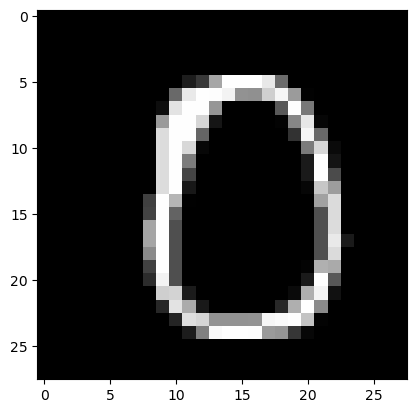

In [ ]:
plt.imshow(X_train[6].reshape(28, 28), cmap="gray"), y_train[6]

# Normalize the inputs to zero mean and unit variance

In [ ]:
def preprocess(X, y):

    X = X / 255.0
    mean = X.mean()
    std = X.std()
    X = (X - mean) / std

    X = X.reshape(X.shape[0], -1)

    num_classes = len(np.unique(y))
    return X, np.eye(num_classes)[y]

X_train, y_train_one_hot = preprocess(X_train, y_train)
X_val, y_val_one_hot = preprocess(X_val, y_val)

# Train the network with given configuration

As given as the base line model we will train the network according to the given configuration.

Default :
- $\eta = 0.01$
- Initialization method : Glorot
- Activation : Sigmoid
- Loss function : Cross Entropy
- Output function : Softmax

Hidden Layers :
- $h_1 = 500$
- $h_2 = 250$
- $h_3 = 100$
- $i/p = 28 \times 28 = 764 \times 1$ (After flattening)
- $o/p = 10 \times 1$ (Number of classes)

Number of epochs : $15$

In [ ]:
baselineModel = FeedForwardNeuralNets(X_train, [500, 250, 100], y_train_one_hot, optimizer="gd", batch_size=64)


start_time = datetime.now()



baselineModel.train(epochs=15, validation_data=[X_val, y_val_one_hot])


end_time = datetime.now()

time_taken = end_time - start_time
print(f"Total time taken for training: {time_taken}")

# This cell takes to run approx. 44 mins with a 8 core CPU

Epoch 1/15, Training Loss: 2.3346, Validation Loss: 2.3094
Epoch 2/15, Training Loss: 2.2171, Validation Loss: 2.1922
Epoch 3/15, Training Loss: 1.9972, Validation Loss: 1.8870
Epoch 4/15, Training Loss: 1.5686, Validation Loss: 1.4182
Epoch 5/15, Training Loss: 1.1994, Validation Loss: 1.1047
Epoch 6/15, Training Loss: 0.9789, Validation Loss: 0.9207
Epoch 7/15, Training Loss: 0.8371, Validation Loss: 0.7936
Epoch 8/15, Training Loss: 0.7298, Validation Loss: 0.7354
Epoch 9/15, Training Loss: 0.6592, Validation Loss: 0.6320
Epoch 10/15, Training Loss: 0.5953, Validation Loss: 0.5839
Epoch 11/15, Training Loss: 0.5517, Validation Loss: 0.5399
Epoch 12/15, Training Loss: 0.5212, Validation Loss: 0.5037
Epoch 13/15, Training Loss: 0.4858, Validation Loss: 0.5226
Epoch 14/15, Training Loss: 0.4673, Validation Loss: 0.4718
Epoch 15/15, Training Loss: 0.4487, Validation Loss: 0.4499
Total time taken for training: 0:44:24.319133


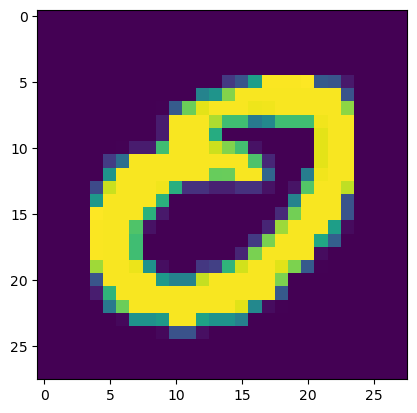

In [ ]:
plt.imshow(X_val[6].reshape(28, 28))

In [ ]:
baselineModel.predict(X_val[600]), y_val[600]

(5, 5)

# Plotting the Train and validation loss for every 200 iterations for baseline model

We will try to plot how the loss varies for every 200 iterations.

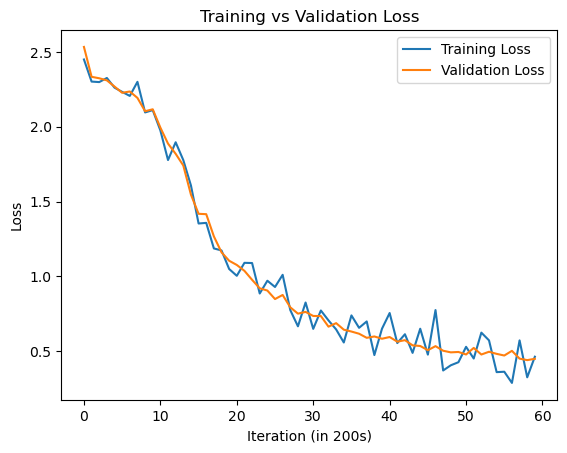

In [ ]:
x_axis = np.arange(60)
train_loss = np.array(baselineModel.training_loss)
validation_loss = np.array(baselineModel.validation_loss)

plt.plot(x_axis, train_loss, label='Training Loss')
plt.plot(x_axis, validation_loss, label='Validation Loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Iteration (in 200s)')
plt.ylabel('Loss')


plt.legend()
plt.savefig('training_vs_validation_loss.png')
plt.show()

# Testing with actualy test data

In [ ]:
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)


X_test, y_test = next(iter(test_loader))
X_test = X_test.numpy()
y_test = y_test.numpy()

X_test, y_test_one_hot = preprocess(X_test, y_test)

In [ ]:
X_train.shape, X_test.shape

((50000, 784), (10000, 784))

In [ ]:
baselineModel.predict(X_test[6]), y_test[6]

(4, 4)

# Calculate Loss for test data and plot it

In [ ]:
test_losses = []


for x, y_true in zip(X_test, y_test_one_hot):
    y_pred = baselineModel.forward_propogation(x)
    loss = baselineModel.L(y_pred, y_true, list(baselineModel.parameters))
    test_losses.append(loss)


test_losses = np.array(test_losses)
test_losses

array([0.01107608, 0.07231415, 0.03132954, ..., 0.90026971, 0.14412548,
       0.10986916])

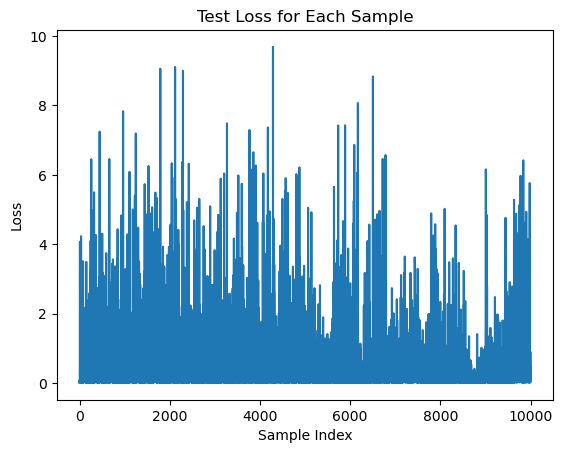

In [ ]:
plt.plot(test_losses)
plt.title('Test Loss for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Loss')
plt.show()

# Classification Report

## Train Data

In [ ]:
y_train_pred = []
for x in X_train:
    y_pred = baselineModel.predict(x)
    y_train_pred.append(y_pred)

y_train_pred = np.array(y_train_pred)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      4968
           1       0.87      0.98      0.92      5689
           2       0.86      0.86      0.86      4967
           3       0.84      0.86      0.85      5141
           4       0.92      0.78      0.84      4872
           5       0.85      0.79      0.82      4524
           6       0.97      0.86      0.91      4932
           7       0.72      0.96      0.83      5192
           8       0.90      0.77      0.83      4832
           9       0.77      0.68      0.72      4883

    accuracy                           0.85     50000
   macro avg       0.86      0.85      0.85     50000
weighted avg       0.86      0.85      0.85     50000



## Test data

In [ ]:
y_test_pred = []
for x in X_test:
    y_pred = baselineModel.predict(x)
    y_test_pred.append(y_pred)

y_test_pred = np.array(y_test_pred)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       980
           1       0.90      0.99      0.94      1135
           2       0.87      0.86      0.86      1032
           3       0.83      0.88      0.86      1010
           4       0.90      0.78      0.84       982
           5       0.85      0.77      0.81       892
           6       0.97      0.84      0.90       958
           7       0.73      0.95      0.83      1028
           8       0.91      0.77      0.84       974
           9       0.79      0.72      0.76      1009

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



# Using different activation functions to train the model

We will use two activation functions mentioned below and train our model

- $\text{Tanh}$
- $\text{ReLU}$

## Using Tanh

In [ ]:
model_tanh = FeedForwardNeuralNets(X_train, [500, 250, 100], y_train_one_hot, optimizer="gd", batch_size=64, g=Activations.Tanh())


start_time = datetime.now()



model_tanh.train(epochs=15, validation_data=[X_val, y_val_one_hot])


end_time = datetime.now()

time_taken = end_time - start_time
print(f"Total time taken for training: {time_taken}")

# This cell runs for 57 mins


Epoch 1/15, Training Loss: 0.8020, Validation Loss: 0.6118
Epoch 2/15, Training Loss: 0.4991, Validation Loss: 0.6735
Epoch 3/15, Training Loss: 0.4243, Validation Loss: 0.3930
Epoch 4/15, Training Loss: 0.3991, Validation Loss: 0.4073
Epoch 5/15, Training Loss: 0.3590, Validation Loss: 0.3651
Epoch 6/15, Training Loss: 0.3477, Validation Loss: 0.3610
Epoch 7/15, Training Loss: 0.3028, Validation Loss: 0.2737
Epoch 8/15, Training Loss: 0.2937, Validation Loss: 0.2821
Epoch 9/15, Training Loss: 0.2928, Validation Loss: 0.2897
Epoch 10/15, Training Loss: 0.2627, Validation Loss: 0.2608
Epoch 11/15, Training Loss: 0.2649, Validation Loss: 0.2623
Epoch 12/15, Training Loss: 0.2462, Validation Loss: 0.2625
Epoch 13/15, Training Loss: 0.2376, Validation Loss: 0.2231
Epoch 14/15, Training Loss: 0.2520, Validation Loss: 0.2511
Epoch 15/15, Training Loss: 0.2275, Validation Loss: 0.2076
Total time taken for training: 0:57:37.176801


## Using ReLU

In [ ]:
model_relu = FeedForwardNeuralNets(X_train, [500, 250, 100], y_train_one_hot, optimizer="gd", batch_size=64, g=Activations.ReLU())


start_time = datetime.now()



model_relu.train(epochs=15, validation_data=[X_val, y_val_one_hot])


end_time = datetime.now()

time_taken = end_time - start_time
print(f"Total time taken for training: {time_taken}")

# This cell takes 57 mins 53 seconds in total

Epoch 1/15, Training Loss: 0.9837, Validation Loss: 0.6321
Epoch 2/15, Training Loss: 0.5767, Validation Loss: 0.4795
Epoch 3/15, Training Loss: 0.4467, Validation Loss: 0.4052
Epoch 4/15, Training Loss: 0.4186, Validation Loss: 0.3829
Epoch 5/15, Training Loss: 0.4126, Validation Loss: 0.4309
Epoch 6/15, Training Loss: 0.3590, Validation Loss: 0.3217
Epoch 7/15, Training Loss: 0.3294, Validation Loss: 0.3133
Epoch 8/15, Training Loss: 0.3318, Validation Loss: 0.3401
Epoch 9/15, Training Loss: 0.2767, Validation Loss: 0.2654
Epoch 10/15, Training Loss: 0.3018, Validation Loss: 0.2672
Epoch 11/15, Training Loss: 0.2871, Validation Loss: 0.2572
Epoch 12/15, Training Loss: 0.2847, Validation Loss: 0.3320
Epoch 13/15, Training Loss: 0.2931, Validation Loss: 0.2698
Epoch 14/15, Training Loss: 0.2455, Validation Loss: 0.2559
Epoch 15/15, Training Loss: 0.2233, Validation Loss: 0.2131
Total time taken for training: 0:57:53.821745


# Plotting the Train and validation loss for every 200 iterations for $\text{Tanh}$ model

We will try to plot how the loss varies for every 200 iterations.

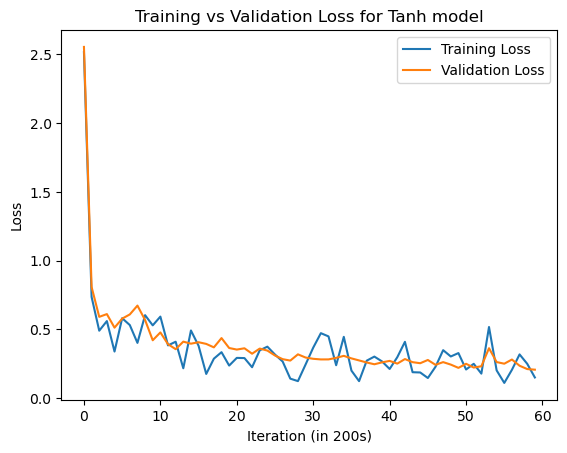

In [ ]:
x_axis = np.arange(60)
train_loss = np.array(model_tanh.training_loss)
validation_loss = np.array(model_tanh.validation_loss)

plt.plot(x_axis, train_loss, label='Training Loss')
plt.plot(x_axis, validation_loss, label='Validation Loss')

plt.title('Training vs Validation Loss for Tanh model')
plt.xlabel('Iteration (in 200s)')
plt.ylabel('Loss')


plt.legend()
plt.savefig('training_vs_validation_loss_tanh.png')
plt.show()

# Plotting the Train and validation loss for every 200 iterations for $\text{ReLU}$ model

We will try to plot how the loss varies for every 200 iterations.

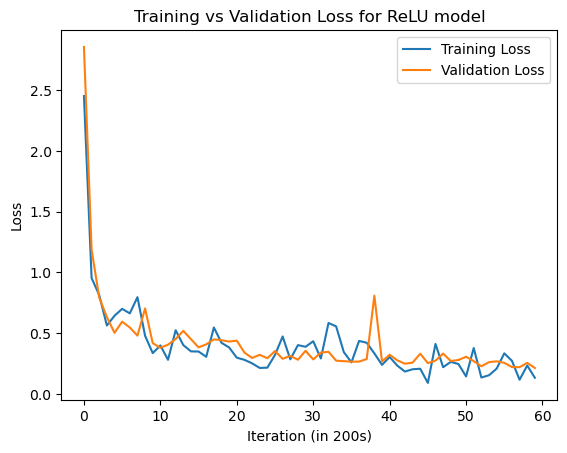

In [ ]:
x_axis = np.arange(60)
train_loss = np.array(model_relu.training_loss)
validation_loss = np.array(model_relu.validation_loss)

plt.plot(x_axis, train_loss, label='Training Loss')
plt.plot(x_axis, validation_loss, label='Validation Loss')

plt.title('Training vs Validation Loss for ReLU model')
plt.xlabel('Iteration (in 200s)')
plt.ylabel('Loss')


plt.legend()
plt.savefig('training_vs_validation_loss_relu.png')
plt.show()

# Classification report for $\text{Tanh}$ and $\text{ReLU}$

## $\text{Tanh}$

Train Data

In [ ]:
y_train_pred_tanh = []
for x in X_train:
    y_pred = model_tanh.predict(x)
    y_train_pred_tanh.append(y_pred)

y_train_pred_tanh = np.array(y_train_pred_tanh)
print(classification_report(y_train, y_train_pred_tanh))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4968
           1       0.98      0.98      0.98      5689
           2       0.93      0.95      0.94      4967
           3       0.94      0.90      0.92      5141
           4       0.96      0.89      0.92      4872
           5       0.95      0.89      0.92      4524
           6       0.98      0.93      0.95      4932
           7       0.97      0.90      0.93      5192
           8       0.85      0.94      0.89      4832
           9       0.82      0.96      0.88      4883

    accuracy                           0.93     50000
   macro avg       0.93      0.93      0.93     50000
weighted avg       0.93      0.93      0.93     50000



## $\text{Tanh}$
Test Data

In [ ]:
y_test_pred_tanh = []
for x in X_test:
    y_pred = model_tanh.predict(x)
    y_test_pred_tanh.append(y_pred)

y_test_pred_tanh = np.array(y_test_pred_tanh)
print(classification_report(y_test, y_test_pred_tanh))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.92      0.94      0.93      1032
           3       0.93      0.91      0.92      1010
           4       0.96      0.89      0.93       982
           5       0.94      0.89      0.91       892
           6       0.98      0.91      0.94       958
           7       0.95      0.88      0.92      1028
           8       0.87      0.93      0.90       974
           9       0.83      0.95      0.89      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



## $\text{ReLU}$

Train data

In [ ]:
y_train_pred_relu = []
for x in X_train:
    y_pred = model_relu.predict(x)
    y_train_pred_relu.append(y_pred)

y_train_pred_relu = np.array(y_train_pred_relu)
print(classification_report(y_train, y_train_pred_relu))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4968
           1       0.99      0.97      0.98      5689
           2       0.91      0.96      0.94      4967
           3       0.96      0.92      0.94      5141
           4       0.94      0.95      0.94      4872
           5       0.88      0.95      0.91      4524
           6       0.96      0.96      0.96      4932
           7       0.96      0.93      0.95      5192
           8       0.95      0.88      0.91      4832
           9       0.92      0.91      0.91      4883

    accuracy                           0.94     50000
   macro avg       0.94      0.94      0.94     50000
weighted avg       0.94      0.94      0.94     50000



In [ ]:
y_test_pred_relu = []
for x in X_test:
    y_pred = model_relu.predict(x)
    y_test_pred_relu.append(y_pred)

y_test_pred_relu = np.array(y_test_pred_relu)
print(classification_report(y_test, y_test_pred_relu))

# The output is there in the report. Please look at that

# Regularization on the better model

We see that $\text{ReLU}$ performs better than sigmoid and $\text{Tanh}$. So we will perform $L_2$ regularization on model $\text{ReLU}$

In [ ]:
cross_entropy_reg_l2 = LossFunctions.CrossEntropyLoss(regularization='l2', alpha=0.01)

model_relu_l2 = FeedForwardNeuralNets(X_train, [500, 250, 100], y_train_one_hot, optimizer="gd", batch_size=64, g=Activations.ReLU(),
                                  L=cross_entropy_reg_l2)


start_time = datetime.now()



model_relu_l2.train(epochs=15, validation_data=[X_val, y_val_one_hot])


end_time = datetime.now()

time_taken = end_time - start_time
print(f"Total time taken for training: {time_taken}")

# Total time taken : 1 hr 06 mins

Epoch 1/15, Training Loss: 11.3984, Validation Loss: 10.7624
Epoch 2/15, Training Loss: 9.5719, Validation Loss: 9.1938
Epoch 3/15, Training Loss: 8.3015, Validation Loss: 8.1260
Epoch 4/15, Training Loss: 7.2534, Validation Loss: 7.4504
Epoch 5/15, Training Loss: 6.3233, Validation Loss: 6.1156
Epoch 6/15, Training Loss: 5.5729, Validation Loss: 5.4898
Epoch 7/15, Training Loss: 4.9239, Validation Loss: 4.7039
Epoch 8/15, Training Loss: 4.3336, Validation Loss: 4.2440
Epoch 9/15, Training Loss: 3.8721, Validation Loss: 3.6975
Epoch 10/15, Training Loss: 3.4169, Validation Loss: 3.2924
Epoch 11/15, Training Loss: 3.0496, Validation Loss: 2.9853
Epoch 12/15, Training Loss: 2.7812, Validation Loss: 2.7342
Epoch 13/15, Training Loss: 2.5181, Validation Loss: 2.4351
Epoch 14/15, Training Loss: 2.2807, Validation Loss: 2.2350
Epoch 15/15, Training Loss: 2.0902, Validation Loss: 2.0112
Total time taken for training: 1:03:26.456915


# Plotting graphs and getting classification report

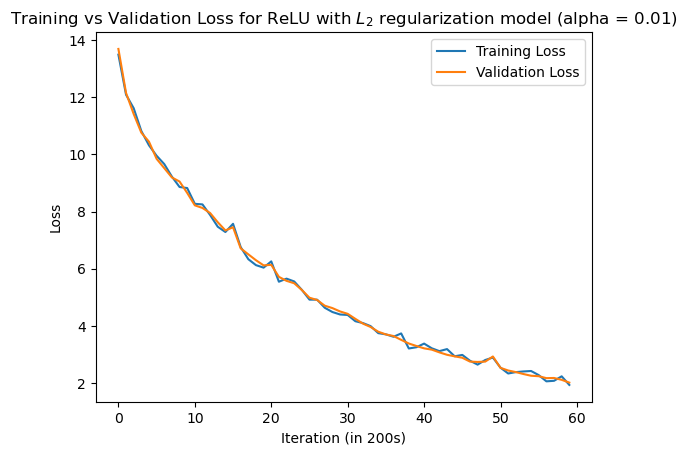

In [ ]:
x_axis = np.arange(60)
train_loss = np.array(model_relu_l2.training_loss)
validation_loss = np.array(model_relu_l2.validation_loss)

plt.plot(x_axis, train_loss, label='Training Loss')
plt.plot(x_axis, validation_loss, label='Validation Loss')

plt.title('Training vs Validation Loss for ReLU with $L_2$ regularization model (alpha = 0.01)')
plt.xlabel('Iteration (in 200s)')
plt.ylabel('Loss')


plt.legend()
plt.savefig('training_vs_validation_loss_relu_l2.png')
plt.show()

In [ ]:
y_train_pred_relu_l2 = []
for x in X_train:
    y_pred = model_relu_l2.predict(x)
    y_train_pred_relu_l2.append(y_pred)

y_train_pred_relu_l2 = np.array(y_train_pred_relu_l2)
print(classification_report(y_train, y_train_pred_relu_l2))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4968
           1       0.65      0.98      0.79      5689
           2       0.87      0.72      0.79      4967
           3       0.89      0.62      0.73      5141
           4       0.77      0.85      0.81      4872
           5       0.73      0.78      0.76      4524
           6       0.82      0.92      0.87      4932
           7       0.72      0.89      0.80      5192
           8       0.78      0.58      0.66      4832
           9       0.84      0.47      0.60      4883

    accuracy                           0.78     50000
   macro avg       0.80      0.78      0.77     50000
weighted avg       0.79      0.78      0.77     50000



# Experiments with different models

In [ ]:
simple_model = FeedForwardNeuralNets(X_train, [60, 60], y_train_one_hot, optimizer='adam', batch_size=128, g=Activations.ReLU())

start_time = datetime.now()



simple_model.train(epochs=15, validation_data=[X_val, y_val_one_hot])


end_time = datetime.now()

time_taken = end_time - start_time
print(f"Total time taken for training: {time_taken}")

# Total time taken : 5 min 54 sec

Epoch 1/15, Training Loss: 2.0271, Validation Loss: 2.0511
Epoch 2/15, Training Loss: 1.6989, Validation Loss: 1.3248
Epoch 3/15, Training Loss: 1.9417, Validation Loss: 2.5326
Epoch 4/15, Training Loss: 1.7098, Validation Loss: 1.4595
Epoch 5/15, Training Loss: 1.5395, Validation Loss: 1.3042
Epoch 6/15, Training Loss: 1.4193, Validation Loss: 1.4811
Epoch 7/15, Training Loss: 1.3879, Validation Loss: 1.3884
Epoch 8/15, Training Loss: 1.2468, Validation Loss: 1.4849
Epoch 9/15, Training Loss: 1.3437, Validation Loss: 1.3594
Epoch 10/15, Training Loss: 1.5493, Validation Loss: 1.4520
Epoch 11/15, Training Loss: 1.6902, Validation Loss: 1.5791
Epoch 12/15, Training Loss: 1.5291, Validation Loss: 1.6458
Epoch 13/15, Training Loss: 1.6245, Validation Loss: 1.8170
Epoch 14/15, Training Loss: 1.6224, Validation Loss: 1.7843
Epoch 15/15, Training Loss: 1.8279, Validation Loss: 1.4440
Total time taken for training: 0:05:54.533827


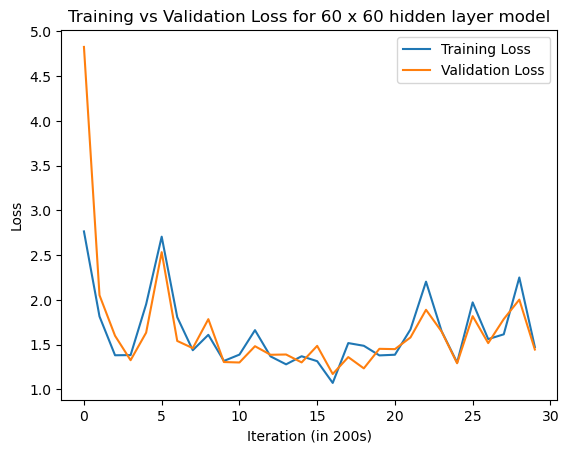

In [ ]:
x_axis = np.arange(30)
train_loss = np.array(simple_model.training_loss)
validation_loss = np.array(simple_model.validation_loss)

plt.plot(x_axis, train_loss, label='Training Loss')
plt.plot(x_axis, validation_loss, label='Validation Loss')

plt.title('Training vs Validation Loss for 60 x 60 hidden layer model')
plt.xlabel('Iteration (in 200s)')
plt.ylabel('Loss')


plt.legend()
plt.savefig('training_vs_validation_loss_rsimple.png')
plt.show()

In [ ]:
y_train_pred_simple = []
for x in X_train:
    y_pred = simple_model.predict(x)
    y_train_pred_simple.append(y_pred)

y_train_pred_simple = np.array(y_train_pred_simple)
print(classification_report(y_train, y_train_pred_simple))

              precision    recall  f1-score   support

           0       0.98      0.66      0.79      4968
           1       0.24      0.99      0.39      5689
           2       0.90      0.55      0.68      4967
           3       0.87      0.36      0.51      5141
           4       0.47      0.79      0.59      4872
           5       0.03      0.00      0.00      4524
           6       1.00      0.12      0.21      4932
           7       0.96      0.72      0.83      5192
           8       0.01      0.00      0.00      4832
           9       0.20      0.18      0.19      4883

    accuracy                           0.45     50000
   macro avg       0.57      0.44      0.42     50000
weighted avg       0.57      0.45      0.43     50000



In [ ]:
simple_model_tanh = FeedForwardNeuralNets(X_train, [75, 100, 60], y_train_one_hot, optimizer='adam', batch_size=128, g=Activations.Tanh())

start_time = datetime.now()



simple_model_tanh.train(epochs=15, validation_data=[X_val, y_val_one_hot])


end_time = datetime.now()

time_taken = end_time - start_time
print(f"Total time taken for training: {time_taken}")

# Total time taken :

Epoch 1/15, Training Loss: 2.8796, Validation Loss: 2.7155
Epoch 2/15, Training Loss: 2.7369, Validation Loss: 2.4332
Epoch 3/15, Training Loss: 2.7762, Validation Loss: 3.0455
Epoch 4/15, Training Loss: 2.8017, Validation Loss: 2.5939
Epoch 5/15, Training Loss: 2.6731, Validation Loss: 2.6385
Epoch 6/15, Training Loss: 2.7330, Validation Loss: 2.6124
Epoch 7/15, Training Loss: 2.8385, Validation Loss: 3.1715
Epoch 8/15, Training Loss: 2.8315, Validation Loss: 2.9605
Epoch 9/15, Training Loss: 2.7560, Validation Loss: 2.6486
Epoch 10/15, Training Loss: 2.7437, Validation Loss: 2.6045
Epoch 11/15, Training Loss: 2.7349, Validation Loss: 2.6444
Epoch 12/15, Training Loss: 2.7772, Validation Loss: 2.7866
Epoch 13/15, Training Loss: 2.8654, Validation Loss: 3.2698
Epoch 14/15, Training Loss: 2.7987, Validation Loss: 3.0186
Epoch 15/15, Training Loss: 2.7348, Validation Loss: 2.8175
Total time taken for training: 0:07:12.886348


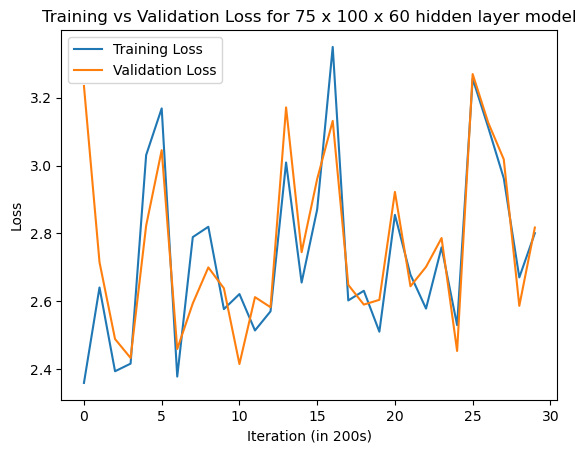

In [ ]:
x_axis = np.arange(30)
train_loss = np.array(simple_model_tanh.training_loss)
validation_loss = np.array(simple_model_tanh.validation_loss)

plt.plot(x_axis, train_loss, label='Training Loss')
plt.plot(x_axis, validation_loss, label='Validation Loss')

plt.title('Training vs Validation Loss for 75 x 100 x 60 hidden layer model')
plt.xlabel('Iteration (in 200s)')
plt.ylabel('Loss')


plt.legend()
plt.savefig('training_vs_validation_loss_rsimple.png')
plt.show()

In [ ]:
y_train_pred_simple = []
for x in X_train:
    y_pred = simple_model.predict(x)
    y_train_pred_simple.append(y_pred)

y_train_pred_simple = np.array(y_train_pred_simple)
print(classification_report(y_train, y_train_pred_simple))

              precision    recall  f1-score   support

           0       0.98      0.66      0.79      4968
           1       0.24      0.99      0.39      5689
           2       0.90      0.55      0.68      4967
           3       0.87      0.36      0.51      5141
           4       0.47      0.79      0.59      4872
           5       0.03      0.00      0.00      4524
           6       1.00      0.12      0.21      4932
           7       0.96      0.72      0.83      5192
           8       0.01      0.00      0.00      4832
           9       0.20      0.18      0.19      4883

    accuracy                           0.45     50000
   macro avg       0.57      0.44      0.42     50000
weighted avg       0.57      0.45      0.43     50000



# Using packages to mimic the same network

In [4]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, g=nn.Sigmoid(), O=nn.Softmax(dim=1)):
        super(MLP, self).__init__()
        layers = []
        layer_sizes = [input_size] + hidden_layers
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            layers.append(g)

        layers.append(nn.Linear(layer_sizes[-1], output_size))
        layers.append(O)

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Trial Run

In [5]:
import torch
from torch.utils.data import DataLoader, random_split


batch_size = 64



train_size = int(0.8 * len(training_data))
val_size = len(training_data) - train_size
train_data, val_data = random_split(training_data, [train_size, val_size])


train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [6]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, input_size=28*28, device='cpu'):
    """
    Trains the given model on the provided dataset using GPU if available.

    Args:
    - model: The neural network model (an instance of nn.Module).
    - train_loader: DataLoader for the training dataset.
    - val_loader: DataLoader for the validation/test dataset.
    - criterion: Loss function.
    - optimizer: Optimizer.
    - epochs: Number of epochs to train the model.
    - input_size: Size of the flattened input (e.g., 28*28 for MNIST).
    - device: Device to use for computation ('cpu' or 'cuda').

    Returns:
    - train_losses: List of training losses per epoch.
    - val_losses: List of validation losses per epoch.
    """

    model.to(device)


    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:

            images, labels = images.view(-1, input_size).to(device), labels.to(device)


            outputs = model(images)
            loss = criterion(outputs, labels)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)


        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.view(-1, input_size).to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")



    return train_losses, val_losses


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


baseline_torch_model = MLP(input_size=28*28, hidden_layers=[500, 250, 100], output_size=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_torch_model.parameters(), lr=0.01)


baseline_torch_model

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=500, out_features=250, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=250, out_features=100, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=100, out_features=10, bias=True)
    (7): Softmax(dim=1)
  )
)

In [9]:
optimizer.defaults

{'lr': 0.01,
 'betas': (0.9, 0.999),
 'eps': 1e-08,
 'weight_decay': 0,
 'amsgrad': False,
 'maximize': False,
 'foreach': None,
 'capturable': False,
 'differentiable': False,
 'fused': None}

In [11]:
train_losses, val_losses = train(baseline_torch_model, train_loader, val_loader, criterion, optimizer, epochs=15, device=device)

Epoch [1/15], Training Loss: 1.7528, Validation Loss: 1.5491
Epoch [2/15], Training Loss: 1.5431, Validation Loss: 1.5396
Epoch [3/15], Training Loss: 1.5271, Validation Loss: 1.5226
Epoch [4/15], Training Loss: 1.5223, Validation Loss: 1.5144
Epoch [5/15], Training Loss: 1.5182, Validation Loss: 1.5173
Epoch [6/15], Training Loss: 1.5156, Validation Loss: 1.5175
Epoch [7/15], Training Loss: 1.5158, Validation Loss: 1.5130
Epoch [8/15], Training Loss: 1.5122, Validation Loss: 1.5107
Epoch [9/15], Training Loss: 1.5115, Validation Loss: 1.5149
Epoch [10/15], Training Loss: 1.5124, Validation Loss: 1.5137
Epoch [11/15], Training Loss: 1.5104, Validation Loss: 1.5134
Epoch [12/15], Training Loss: 1.5100, Validation Loss: 1.5194
Epoch [13/15], Training Loss: 1.5127, Validation Loss: 1.5137
Epoch [14/15], Training Loss: 1.5076, Validation Loss: 1.5134
Epoch [15/15], Training Loss: 1.5082, Validation Loss: 1.5209


## Plotting a train and validation curve

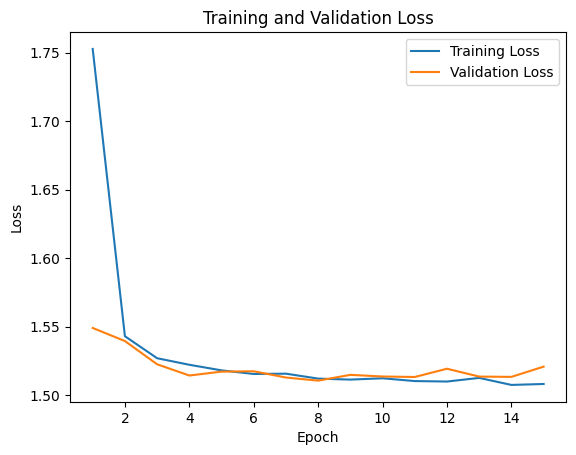

In [12]:
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [25]:
def evaluate_data_with_predictions(model, data_loader, criterion, input_size=28*28, device='cpu'):
    """
    Evaluates the model on the entire dataset and returns predictions, test loss, and accuracy.

    Args:
    - model: The trained neural network model.
    - test_loader: DataLoader for the test dataset.
    - criterion: The loss function to calculate the test loss.
    - input_size: Size of the flattened input (e.g., 28*28 for MNIST).
    - device: Device to use for computation ('cpu' or 'cuda').

    Returns:
    - avg_test_loss: The average test loss over the test dataset.
    - accuracy: The accuracy of the model on the test dataset.
    - all_predictions: The list of all predicted labels for the test dataset.
    - all_true_labels: The list of all true labels from the test dataset.
    """
    model.eval()
    model.to(device)

    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for images, labels in data_loader:

            images, labels = images.view(-1, input_size).to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())


            correct += (predicted == labels).sum().item()
            total += labels.size(0)



    return all_predictions, all_true_labels

In [26]:
y_pred_train, y_true_train = evaluate_data_with_predictions(baseline_torch_model, train_loader, criterion=criterion, device=device)
print(classification_report(y_true_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      4768
           1       0.97      0.99      0.98      5410
           2       0.97      0.94      0.95      4793
           3       0.99      0.87      0.93      4953
           4       0.92      0.96      0.94      4558
           5       0.95      0.96      0.95      4323
           6       0.92      0.99      0.95      4710
           7       0.97      0.95      0.96      5044
           8       0.94      0.89      0.91      4755
           9       0.86      0.93      0.89      4686

    accuracy                           0.94     48000
   macro avg       0.95      0.94      0.94     48000
weighted avg       0.95      0.94      0.94     48000



In [27]:
y_pred_test, y_true_test = evaluate_data_with_predictions(baseline_torch_model, test_loader, criterion=criterion, device=device)
print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.97      0.94      0.96      1032
           3       0.98      0.88      0.92      1010
           4       0.92      0.97      0.95       982
           5       0.94      0.94      0.94       892
           6       0.90      0.97      0.93       958
           7       0.96      0.93      0.94      1028
           8       0.95      0.88      0.92       974
           9       0.86      0.93      0.89      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

